In [10]:

import os
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# ---------- Dataset Class ----------
class ArtworkDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images, self.labels, self.image_filenames = [], [], []
        self.genres = sorted([g for g in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, g))])

        for genre_idx, genre in enumerate(self.genres):
            genre_path = os.path.join(root_dir, genre)
            for img_file in os.listdir(genre_path):
                self.images.append(os.path.join(genre_path, img_file))
                self.labels.append(genre_idx)
                self.image_filenames.append(img_file)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx], self.image_filenames[idx]

    def get_num_classes(self):
        return len(self.genres)

# ---------- GUI for Genre Selection ----------
def select_genre(genres):
    root = tk.Tk()
    root.title("Select a Genre")
    selected_genre = tk.StringVar()

    tk.Label(root, text="Choose a genre to analyze:").pack()
    genre_dropdown = ttk.Combobox(root, textvariable=selected_genre, values=genres, state="readonly")
    genre_dropdown.pack()
    genre_dropdown.set(genres[0])

    def on_submit():
        root.selected_genre = selected_genre.get()
        root.destroy()

    tk.Button(root, text="OK", command=on_submit).pack()
    root.mainloop()
    return root.selected_genre

# ---------- Feature Extraction with Caching ----------
def extract_or_load_features(dataloader, feature_path, label_path, feature_extractor, device):
    if os.path.exists(feature_path) and os.path.exists(label_path):
        print("Loading cached features...")
        features = np.load(feature_path)
        labels = np.load(label_path)
    else:
        print("Extracting features...")
        features, labels = [], []
        with torch.no_grad():
            for images, lbls, _ in dataloader:
                images = images.to(device)
                output = feature_extractor(images)
                gap_output = torch.mean(output, dim=[2, 3])
                features.append(gap_output.cpu().numpy())
                labels.extend(lbls.numpy())
        features = np.vstack(features)
        labels = np.array(labels)

        np.save(feature_path, features)
        np.save(label_path, labels)
        print(f"Features saved to {feature_path}")

    return features, labels

# # ---------- Main Analysis ----------
# def main():
    
# if __name__ == "__main__":
#     main()

dataset_path = "D:\\git\\FYP\\Python\\TwoStage\\data\\similarity\\Dataset1_WI"
#cache_dir = os.path.join(r"D:\git\ECNG3020-ArtGenreClassificationWithWestIndianPaintings\python\similairty\Dataset1_desnet", "VGG-16Features")
cache_dir = os.path.join((r"D:\git\ECNG3020-ArtGenreClassificationWithWestIndianPaintings\python\similairty\Dataset1_desnet", "DensenetFeatures"))
os.makedirs(cache_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = ArtworkDataset(dataset_path, transform)
dataloader = DataLoader(dataset, batch_size=50, shuffle=False)

# Select genre
selected_genre = select_genre(dataset.genres)
selected_genre_idx = dataset.genres.index(selected_genre)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#testing DENSENET
densenet = models.densenet121(pretrained=True).to(device)
feature_extractor = densenet.features
feature_extractor.eval()
feature_file = os.path.join(cache_dir, "dataset1_densenet_features.npy")
label_file = os.path.join(cache_dir, "dataset1_densenet_labels.npy")

#TESTING VGG16
# vgg16 = models.vgg16(pretrained=True).to(device)
# feature_extractor = vgg16.features
# feature_extractor.eval()
# feature_file = os.path.join(cache_dir, "vgg_features.npy")
# label_file = os.path.join(cache_dir, "vgg_labels.npy")

# Extract or load features

features, true_labels = extract_or_load_features(
    dataloader, feature_file, label_file, feature_extractor, device
)

# Similarity analysis
similarity_matrix = cosine_similarity(features)
selected_similarities = similarity_matrix[true_labels == selected_genre_idx].mean(axis=0)
avg_similarity_to_others = selected_similarities[true_labels != selected_genre_idx].mean()

print(f"\nAverage similarity of '{selected_genre}' to other genres: {avg_similarity_to_others:.4f}")
if avg_similarity_to_others < 0.5:
    print(f"'{selected_genre}' appears to be quite unique!")
else:
    print(f"'{selected_genre}' has significant overlap with other genres.")

# Genre-wise similarity
genre_similarities = {}
genre_to_idx = {genre: i for i, genre in enumerate(dataset.genres)}

for genre in dataset.genres:
    if genre != selected_genre:
        mask_sel = (true_labels == selected_genre_idx)
        mask_other = (true_labels == genre_to_idx[genre])
        #cross_sim = similarity_matrix[mask_sel][:, mask_other].mean()
        cross_sim = similarity_matrix[mask_sel][:, mask_other].sum() / (mask_sel.sum() * mask_other.sum())

        genre_similarities[genre] = cross_sim

# Bar Plot of Similarities
# Bar Plot of Similarities
similarity_df = pd.DataFrame({'Genre': list(genre_similarities.keys()), 'Similarity': list(genre_similarities.values())})
similarity_df = similarity_df.sort_values('Similarity', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=similarity_df, x='Genre', y='Similarity')

plt.title(f'Average Similarity between {selected_genre} and Other Genres')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"genre_similarity_{selected_genre}.png", dpi=300)
plt.show()



# Heatmap of genre correlations
corr_matrix = np.zeros((len(dataset.genres), len(dataset.genres)))
for i, genre1 in enumerate(dataset.genres):
    mask1 = (true_labels == genre_to_idx[genre1])
    for j, genre2 in enumerate(dataset.genres):
        mask2 = (true_labels == genre_to_idx[genre2])
        corr_matrix[i, j] = similarity_matrix[mask1][:, mask2].mean()

# Save the correlation matrix to Excel
corr_df = pd.DataFrame(corr_matrix, index=dataset.genres, columns=dataset.genres)

# Create workbook for saving both correlation matrix and bar chart data
with pd.ExcelWriter(f"genre_correlation_matrix_{selected_genre}.xlsx") as writer:
    # Save correlation matrix to first sheet
    corr_df.to_excel(writer, sheet_name='Correlation_Matrix')
    
    # Save bar chart data to second sheet
    similarity_df.to_excel(writer, sheet_name='Genre_Similarities')
    
    # Add a sheet with overall stats
    stats_df = pd.DataFrame({
        'Statistic': ['Selected Genre', 'Average Similarity to Others', 'Number of Genres'],
        'Value': [selected_genre, avg_similarity_to_others, len(dataset.genres)]
    })
    stats_df.to_excel(writer, sheet_name='Summary_Stats', index=False)

print(f"Correlation matrix and similarity data saved to 'genre_correlation_matrix_{selected_genre}.xlsx'")

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f", 
            xticklabels=dataset.genres, yticklabels=dataset.genres)
plt.title('Genre Correlation Matrix Based on Feature Similarity')
plt.tight_layout()
plt.savefig("genre_correlation_matrix.png", dpi=300)
plt.show()



TypeError: expected str, bytes or os.PathLike object, not tuple

<Figure size 1200x800 with 0 Axes>

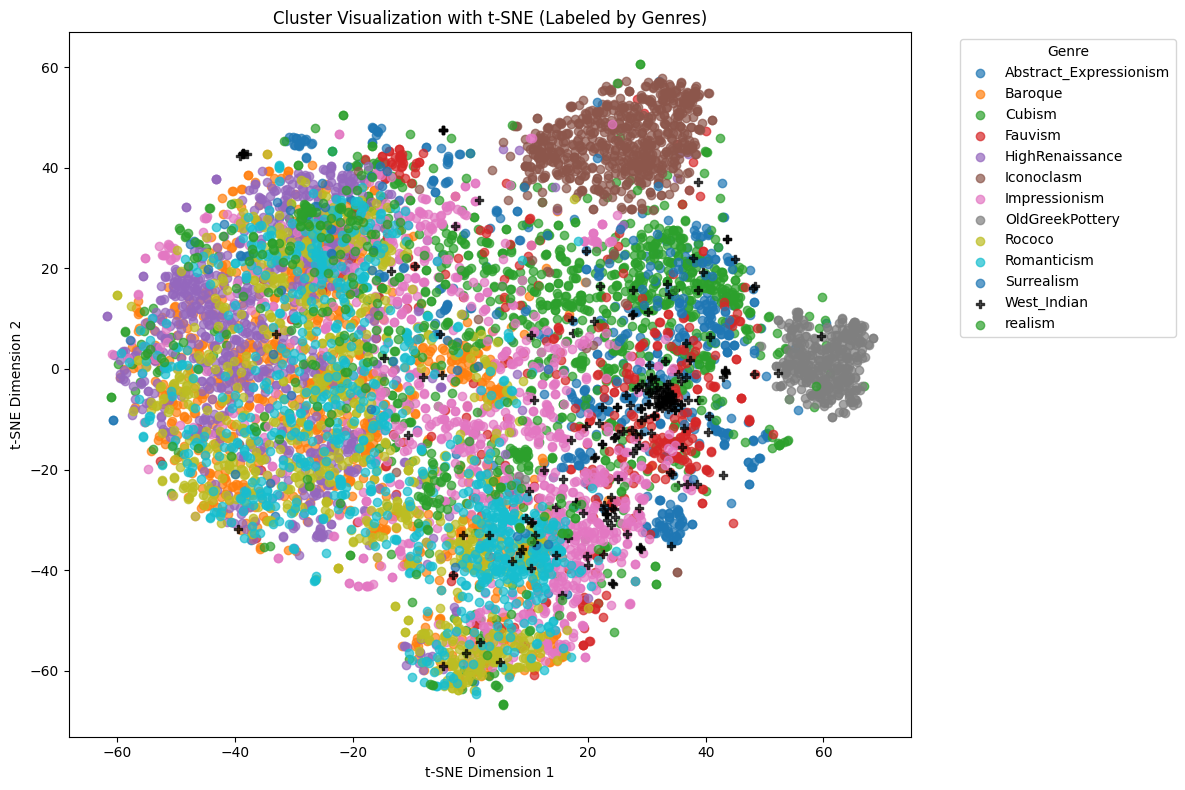

In [ ]:

# Clustering
n_clusters = dataset.get_num_classes()
kmeans = KMeans(n_clusters=dataset.get_num_classes(), random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features)


# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features) - 1))
features_2d = tsne.fit_transform(features)

plot_data = pd.DataFrame(features_2d, columns=['Dim1', 'Dim2'])
plot_data['Cluster'] = cluster_labels
plot_data['Genre'] = [dataset.genres[i] for i in true_labels]
plot_data['Marker'] = 'o'
plot_data.loc[plot_data['Genre'] == selected_genre, 'Marker'] = 'P'  # Selected genre gets cross-like plus symbols


# Plot results
plt.figure(figsize=(12, 8))
palette = sns.color_palette("Set1", n_clusters)  # More distinct colors

# Define a marker style dictionary
marker_styles = {genre: 'o' for genre in dataset.genres}  # Default all to circles
marker_styles[selected_genre] = 's'  # Change only the selected genre to squares

plt.figure(figsize=(12, 8))

# Create a mapping between genres and colors for consistency
genre_colors = {genre: f"C{i}" for i, genre in enumerate(sorted(plot_data['Genre'].unique()))}

# Plot each genre separately with consistent colors
for genre in dataset.genres:
    genre_data = plot_data[plot_data['Genre'] == genre]
    plt.scatter(
        genre_data['Dim1'], 
        genre_data['Dim2'], 
        label=genre,
        marker='P' if genre == selected_genre else 'o',  # 'P' for plus sign
        color='black' if genre == selected_genre else genre_colors[genre],  # Black for selected genre
        alpha=0.7
    )

plt.title('Cluster Visualization with t-SNE (Labeled by Genres)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"tsne_genres.png", dpi=300)
plt.show()



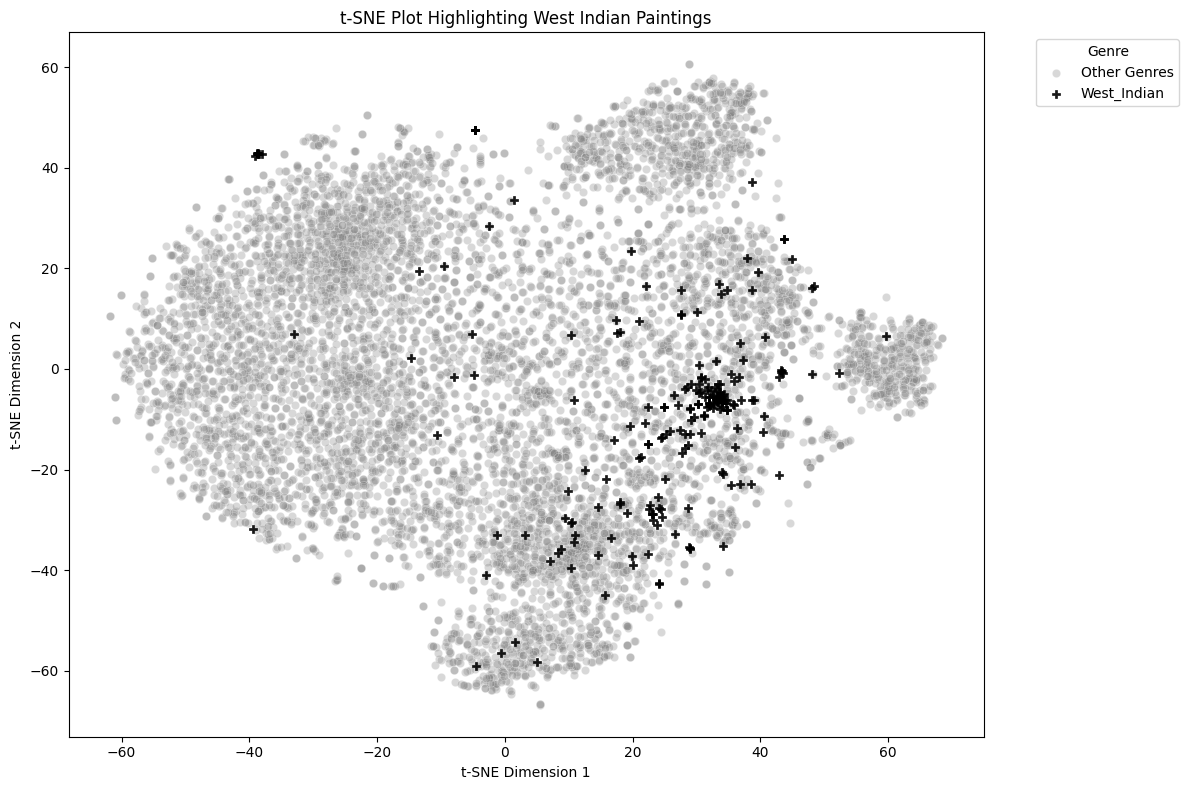

In [ ]:
plt.figure(figsize=(12, 8))

# Plot all other genres as a single "Other Genres" group in grey
sns.scatterplot(
    data=plot_data[plot_data['Genre'] != selected_genre],
    x='Dim1',
    y='Dim2',
    color='gray',
    alpha=0.3,
    marker='o',
    label="Other Genres"
)

# Highlight the selected genre in black with bold plus signs
sns.scatterplot(
    data=plot_data[plot_data['Genre'] == selected_genre],
    x='Dim1',
    y='Dim2',
    color='black',
    marker='P',  # Plus sign
    #s=50,  # Increase marker size for visibility
    edgecolor='black',  # Add edge for emphasis
    #linewidth=1.2,  # Make edges stand out more
    alpha=0.9,
    label=selected_genre
)

# Adjustments
plt.title("t-SNE Plot Highlighting West Indian Paintings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')  # Clean legend
plt.tight_layout()
plt.show()


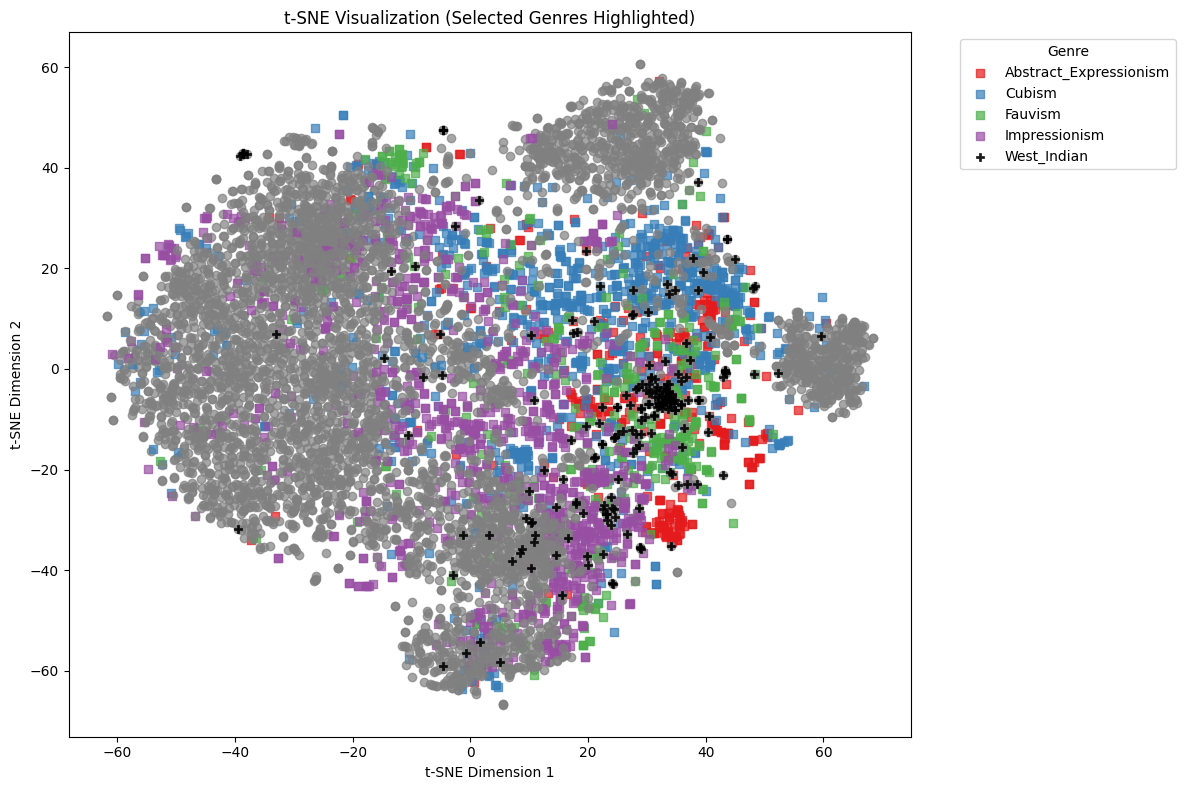

In [ ]:


# Tkinter GUI for selecting multiple genres
def select_genres(genres):
    root = tk.Tk()
    root.title("Select Genres")

    selected_genres = []
    
    def on_submit():
        selected_genres.extend([genre for genre, var in genre_vars.items() if var.get()])
        root.destroy()

    tk.Label(root, text="Choose genres to highlight:").pack()
    
    genre_vars = {genre: tk.BooleanVar() for genre in genres}
    for genre, var in genre_vars.items():
        chk = tk.Checkbutton(root, text=genre, variable=var)
        chk.pack(anchor="w")
    
    submit_button = tk.Button(root, text="OK", command=on_submit)
    submit_button.pack()
    
    root.mainloop()
    return selected_genres

# Select multiple genres for highlighting
selected_genres = select_genres(dataset.genres)
selected_genre_indices = [dataset.genres.index(genre) for genre in selected_genres]


# Compute Cosine Similarity
similarity_matrix = cosine_similarity(features)

# Ensure you're working with one of the selected genres
for selected_genre_idx in selected_genre_indices:
    selected_genre_similarities = similarity_matrix[true_labels == selected_genre_idx].mean(axis=0)
    avg_similarity_to_others = selected_genre_similarities[true_labels != selected_genre_idx].mean()

    # # Print uniqueness assessment
    # selected_genre = dataset.genres[selected_genre_idx]
    # print(f"Average similarity of '{selected_genre}' to other genres: {avg_similarity_to_others:.4f}")
    # if avg_similarity_to_others < 0.5:
    #     print(f"'{selected_genre}' appears to be quite unique!")
    # else:
    #     print(f"'{selected_genre}' has significant overlap with other genres.")



# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features) - 1))
features_2d = tsne.fit_transform(features)

plot_data = pd.DataFrame(features_2d, columns=['Dim1', 'Dim2'])
plot_data['Cluster'] = cluster_labels
plot_data['Genre'] = [dataset.genres[i] for i in true_labels]
plot_data['Marker'] = 'o'
plot_data.loc[plot_data['Genre'].isin(selected_genres), 'Marker'] = 's'  # Selected genres get squares

# Plot results
plt.figure(figsize=(12, 8))
palette = sns.color_palette("Set1", n_colors=len(selected_genres))  # Unique colors for selected genres

# Define a color mapping for genres
genre_color_map = {genre: "gray" for genre in dataset.genres}  # Default color gray
for i, genre in enumerate(selected_genres):
    genre_color_map[genre] = palette[i]  # Assign unique colors to selected genres

# Plot all genres
for genre in dataset.genres:
    genre_data = plot_data[plot_data['Genre'] == genre]
    plt.scatter(
        genre_data['Dim1'], 
        genre_data['Dim2'], 
        label=genre if genre in selected_genres else None,
        color=genre_color_map[genre],
        alpha=0.7,
        marker=genre_data['Marker'].iloc[0]
    )
sns.scatterplot(
    data=plot_data[plot_data['Genre'] == 'West_Indian'],
    x='Dim1',
    y='Dim2',
    color='black',
    marker='P',  # Plus sign
    #s=50,  # Increase marker size for visibility
    edgecolor='black',  # Add edge for emphasis
    #linewidth=1.2,  # Make edges stand out more
    alpha=0.9,
    label=selected_genre
)
plt.title('t-SNE Visualization (Selected Genres Highlighted)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"tsne_highlighted_genres.png", dpi=300)
plt.show()
